##Эксперименты с моделями

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer


In [ ]:
# Функция для обработки данных
def preprocess_data(X):
    # Заменяем бесконечности на NaN
    X_processed = X.replace([np.inf, -np.inf], np.nan)

    # Находим числовые колонки
    numeric_columns = X_processed.select_dtypes(include=['float64', 'int64']).columns

    # Для каждой числовой колонки заменяем выбросы
    for column in numeric_columns:
        # Вычисляем квантили
        Q1 = X_processed[column].quantile(0.25)
        Q3 = X_processed[column].quantile(0.75)
        IQR = Q3 - Q1

        # Определяем границы выбросов
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Заменяем выбросы на границы
        X_processed[column] = X_processed[column].clip(lower_bound, upper_bound)

    return X_processed

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'\n{model_name} metrics:')
    print(f'MAE: {mae:,.0f}')
    print(f'RMSE: {rmse:,.0f}')
    return mae, rmse

# Подготовка данных
X = df_numeric.drop(columns=['price','sales_live'])
y = df_numeric['price']

# Предобработка данных
X = preprocess_data(X)

# Разделение данных с сохранением временной последовательности
train_size = int(len(X) * 0.8)  # 80% данных для обучения
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

# Создаем импутер для заполнения пропущенных значений
imputer = SimpleImputer(strategy='median')

# Применяем импутер
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Восстанавливаем DataFrame структуру после импутации
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

In [ ]:
# 1. Линейная регрессия
try:
    linear_model = LinearRegression()
    linear_model.fit(X_train_imputed, y_train)
    y_pred_linear = linear_model.predict(X_test_imputed)
    mae_linear, rmse_linear = evaluate_model(y_test, y_pred_linear, 'Linear Regression')
except Exception as e:
    print(f"Error in Linear Regression: {e}")
    mae_linear, rmse_linear = np.nan, np.nan


Linear Regression metrics:
MAE: 85,588
RMSE: 146,721


In [ ]:
# 2. Random Forest
try:
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_imputed, y_train)
    y_pred_rf = rf_model.predict(X_test_imputed)
    mae_rf, rmse_rf = evaluate_model(y_test, y_pred_rf, 'Random Forest')
except Exception as e:
    print(f"Error in Random Forest: {e}")
    mae_rf, rmse_rf = np.nan, np.nan


Random Forest metrics:
MAE: 24,676
RMSE: 59,057


In [ ]:
# 3. XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100,
                            random_state=42,
                            n_jobs=-1,
                            eval_metric='rmse')
xgb_model.fit(X_train_imputed, y_train)
y_pred_xgb = xgb_model.predict(X_test_imputed)
mae_xgb, rmse_xgb = evaluate_model(y_test, y_pred_xgb, 'XGBoost')


XGBoost metrics:
MAE: 75,234
RMSE: 127,149


In [ ]:
# Сравнительная таблица результатов
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'MAE': [mae_linear, mae_rf, mae_xgb],
    'RMSE': [rmse_linear, rmse_rf, rmse_xgb]
})

print('\nComparison of all models:')
print(results_df.to_string(index=False))

# Визуализация результатов
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))


Comparison of all models:
            Model       MAE       RMSE
Linear Regression 85588.356 146720.961
    Random Forest 24676.416  59057.337
          XGBoost 75234.106 127149.265


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

([0, 1, 2],
 [Text(0, 0, 'Linear Regression'),
  Text(1, 0, 'Random Forest'),
  Text(2, 0, 'XGBoost')])

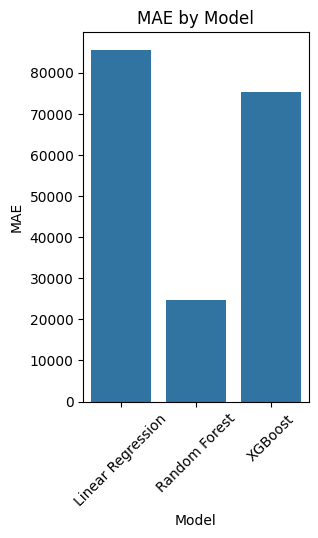

In [ ]:
# График для MAE
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='MAE', data=results_df)
plt.title('MAE by Model')
plt.xticks(rotation=45)

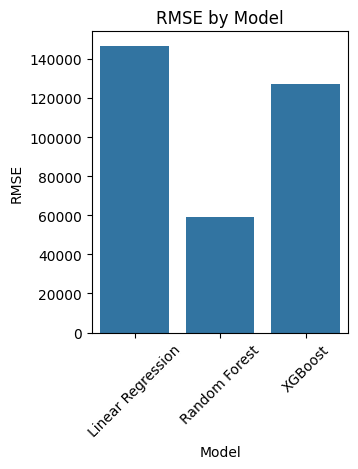

In [ ]:
# График для RMSE
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='RMSE', data=results_df)
plt.title('RMSE by Model')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

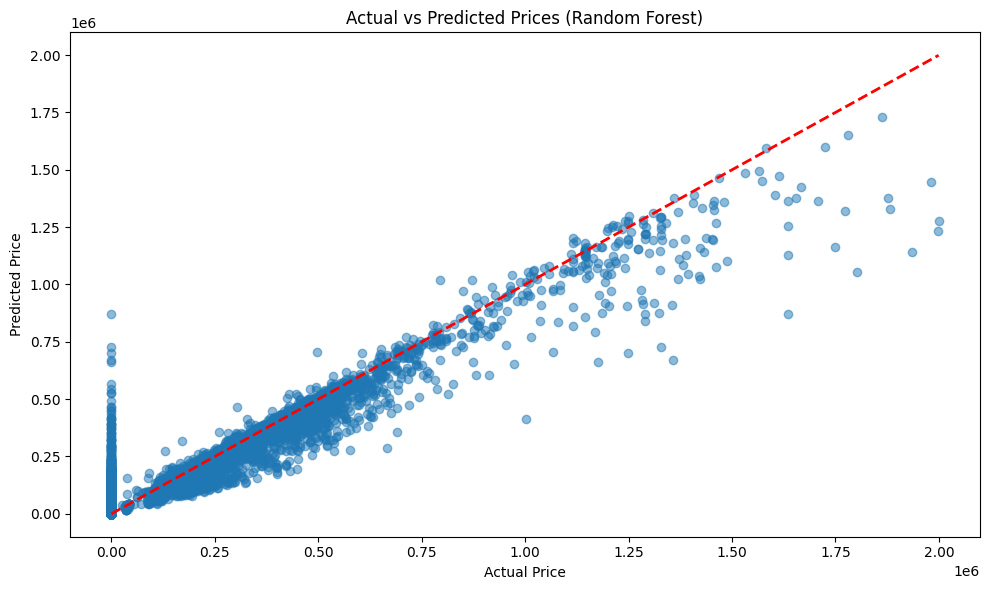

In [ ]:
 #Создаем словарь с предсказаниями
predictions_dict = {
    'Linear Regression': y_pred_linear,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb
}

# Находим лучшую модель
best_model_name = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
best_predictions = predictions_dict[best_model_name]

# Создаем scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Actual vs Predicted Prices ({best_model_name})')
plt.tight_layout()
plt.show()

In [ ]:
# Анализ важности признаков для Random Forest
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 most important features:")
print(feature_importance.head(10))


Top 10 most important features:
                        feature  importance
31                       months       0.134
15                       внутри       0.111
30                         year       0.099
941   Тип помещений_Апартаменты       0.059
1                         ID ЖК       0.029
0                            ID       0.025
964             Класс К_премиум       0.023
602       Район Город_Хамовники       0.022
2933     Двор без машин_да\n1,6       0.021
34         average_price_growth       0.019


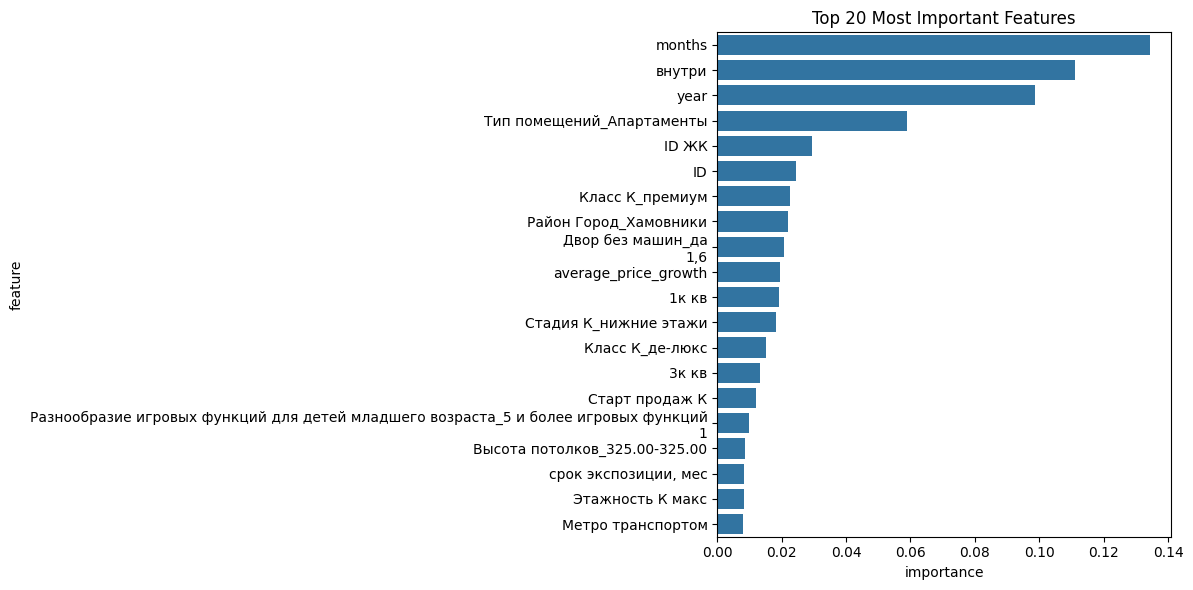

In [ ]:
# Визуализация важности признаков
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()